In [38]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('/home/xilinx/jupyter_notebooks/qickdawg/src/')

import qickdawg as qd
from copy import copy
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
qd.start_client(bitfile="/home/xilinx/jupyter_notebooks/qickdawg/firmware/photon_counting/qick_4x2.bit")

In [40]:
min_step_us = qd.soccfg.cycles2us(1) # this is the minimum step size in us, which is the time for one clock cycle
min_step_ns = min_step_us*1e3
max_int_time_us = min_step_us * (2**16 - 1)
max_int_time_ns = min_step_ns * (2**16 - 1)

In [42]:
default_config = qd.NVConfiguration()

default_config.test = True
default_config.mw_readout_channel = 1
default_config.ddr4 = True
default_config.ddr4_channel = 0
default_config.n_ddr4_chunks = 200

default_config.adc_channel = 0 

default_config.mw_channel = 1
default_config.mw_nqz = 1
default_config.mw_gain = 5000

default_config.laser_gate_pmod = 0

default_config.relax_delay_treg = 100 # between each rep, wait for everything to catch up, mostly aom


In [43]:
config = copy(default_config)

config.soft_avgs = 1
config.readout_integration_treg = 1020
prog = qd.LaserOn(config)
_ = prog.acquire_decimated(progress=False)
data = prog.acquire_decimated(progress=False)
on_value  = np.mean(data)
print('Approximate on intensity {} ADC units'.format(on_value))

prog = qd.LaserOff(config)
_ = prog.acquire_decimated(progress=False)
data = prog.acquire_decimated(progress=False)
off_value  = np.mean(data)
print('Approximate off intensity {} ADC units'.format(off_value))


Approximate on intensity 1707.327450980392 ADC units
Approximate off intensity 2.9794117647058824 ADC units


In [45]:
for i in range(2):
    
    qd.soc.clear_ddr4()

    config = copy(default_config)
    
    config.mw_gain = 30000
    config.mw_fMHz = 2870
    config.mw_pi2_treg = 100
    
    config.pre_init = False

    config.relax_delay_treg = 100

    config.laser_on_treg = 5000 # in us
    config.readout_integration_treg = 700  # us
    config.readout_reference_start_treg = 3500 # us

    config.laser_readout_offset_treg = 0 #
    config.mw_readout_delay_treg = 100

    config.add_linear_sweep('n', '', start=1, stop=10, delta=1)

    config.reps = 1

    config.ddr4_channel = i

    prog = qd.CPMGXY8nSweep(config)
    d = prog.acquire(progress=True)

    if i == 0:
        laser_ddr4 = qd.soc.get_ddr4(config.n_ddr4_chunks)[:, 0]
    elif i == 1:
        mw_ddr4 = qd.soc.get_ddr4(config.n_ddr4_chunks)
        mw_real = mw_ddr4[:, 0]
        mw_imag = mw_ddr4[:, 1]

IndexError: string index out of range

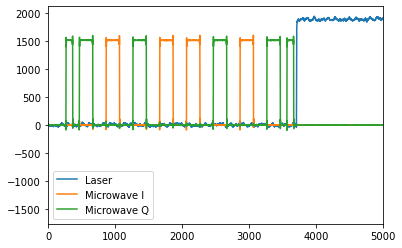

In [7]:
# phase = 0.21
phase = np.arctan(np.mean(mw_real[300:800]) / np.mean(mw_imag[300:800]))
# phase = np.pi/2

x = mw_real * np.cos(phase) - mw_imag * np.sin(phase)
y = mw_real * np.sin(phase) + mw_imag * np.cos(phase)

plt.plot(laser_ddr4, label='Laser')
plt.plot(x, label='Microwave I')
plt.plot(y, label='Microwave Q')
plt.xlim(0, 5000)
plt.legend()

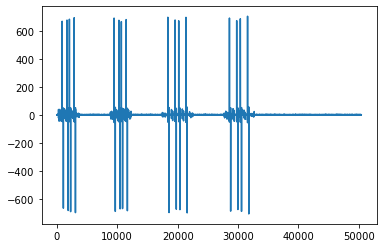

In [8]:
plt.plot(np.gradient(x))

In [9]:
laser_start_treg = find_peaks(np.gradient(laser_ddr4), height=200)[0]
laser_end_treg = find_peaks(np.gradient(-laser_ddr4), height=200)[0]
mw_start_treg = find_peaks(np.gradient(np.abs(x + y)), height=150)[0]
mw_end_treg = find_peaks(np.gradient(-np.abs(x + y)), height=150)[0]

laser_norm = laser_ddr4 /np.max(laser_ddr4)
x_norm = x /np.max(x)
y_norm = -y /np.min(y)

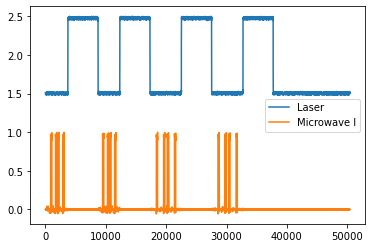

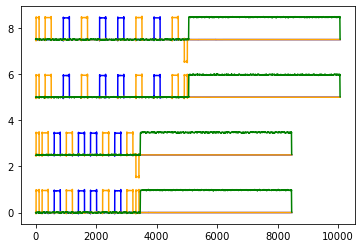

In [10]:
plt.plot(laser_ddr4/np.max(laser_ddr4) + 1.5, label='Laser')
plt.plot(x/np.max(x), label='Microwave I')
# plt.plot(y, label='Microwave Q')
plt.legend()
plt.show()

for i in range(len(laser_end_treg)):
    plt.plot(x_norm[mw_start_treg[10 * i] - 10 : laser_end_treg[i] + 10] + i * 2.5, c='blue')
    plt.plot(y_norm[mw_start_treg[10 * i] - 10 : laser_end_treg[i] + 10] + i * 2.5, c='orange')
    plt.plot(laser_norm[mw_start_treg[10 * i] - 10: laser_end_treg[i] + 10] +  i * 2.5, c='green')

# plt.plot(x_norm[mw_start_treg[1]: laser_end_treg[3]])


In [11]:
# should be equal to the mw pulse time in treg for 2 * pi/2

mw_end_treg - mw_start_treg

array([100, 199, 199, 199, 199, 199, 199, 199, 200, 100, 100, 199, 199,
       199, 199, 199, 199, 200, 199,  99,  99, 200, 199, 200, 200, 200,
       199, 200, 199,  99, 100, 200, 199, 200, 200, 200, 199, 200, 199,
       100])

In [12]:
# should be equal to the readout window time in treg

laser_end_treg - laser_start_treg

array([5000, 5000, 5000, 5000])

In [13]:
[laser_start_treg[i] - mw_end_treg[9 + 10 * i] for i  in range(len(laser_start_treg))]

[42, 43, 43, 42]

In [14]:
# Should be 4 * mw_pi2_treg + 2 * delay_treg + laser_on_treg + mw_readout_delay_treg + laser_readout_offset_treg - adc_trigger_offset_treg
# this should only change by delay * 2 time

sequence_time = []

for i in range(len(laser_start_treg)):
    sequence_time.append(laser_end_treg[i] - mw_start_treg[10 * i])

print([sequence_time[i] - sequence_time[0] for i in range(len(sequence_time))])

[0, 0, 1600, 1600]


In [15]:
print(prog.asm())


// Program

            regwi 1, $22, 626961066;            //freq = 2507844267
            bitwi 1, $22, $22 << 2;
            mathi 1, $22, $22 + 3;
            regwi 1, $25, 30000;                //gain = 30000
            regwi 1, $23, 0;                    //phase = 0
            regwi 1, $26, 589924;               //phrst| stdysel | mode | | outsel = 0b01001 | length = 100 
            regwi 1, $1, 100;                   //'delay' <= 100 
            synci 100;
            regwi 0, $16, 8192;                 //out = 0b0010000000000000
            seti 7, 0, $16, 0;                  //ch =0 out = $16 @t = 0
            seti 7, 0, $0, 10;                  //ch =0 out = 0 @t = 0
            synci 100;
            regwi 0, $13, 0;
            regwi 0, $14, 0;
LOOP_rep:   regwi 1, $1, 100;                   //'delay' <= 100 
            regwi 0, $17, 1;
LOOP_delay: regwi 1, $23, 0;                    //phase = 0
            regwi 1, $26, 589924;               //phrst| stdysel | mode 

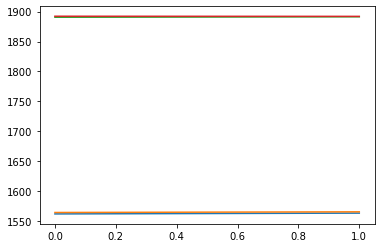

In [16]:
plt.plot(d.signal1/prog.cfg.readout_integration_treg)
plt.plot(d.signal2/prog.cfg.readout_integration_treg)
plt.plot(d.reference1/prog.cfg.readout_integration_treg)
plt.plot(d.reference2/prog.cfg.readout_integration_treg)